In [ ]:
# ! THIS NOTEBOOK IS DESIGNED TO BE RUN ON COLAB, RUNNING ON LOCAL IS NOT RECOMMENDED !

In [ ]:
# REQUIREMENTS
!pip install rawpy imageio dtcwt
!sudo apt-get install libfreeimage3 libfreeimage-dev

In [6]:
import os
import numpy as np
from PIL import Image, ImageDraw
import rawpy
import imageio
from math import sqrt, ceil

In [7]:
# SET URL TO BRACKET FILE
# 10 PHOTOS BRACKET
url = 'https://www.dropbox.com/s/tl97xlfkeafw48b/dng_photos_day_essai_2.zip'
file_name = 'dng_photos_day_essai_2.zip'

In [8]:
# DOWNLOAD ZIP DATA FROM SOURCE AND UNZIP
os.system('rm -rf photos')
os.system('wget -P photos '+ url)
os.system('unzip photos/' + file_name + ' -d photos')
os.system('rm -rf photos/' + file_name)
photos_list = sorted(os.listdir('photos'))
photos_list

['R0013386.DNG',
 'R0013387.DNG',
 'R0013388.DNG',
 'R0013389.DNG',
 'R0013390.DNG',
 'R0013391.DNG',
 'R0013392.DNG',
 'R0013393.DNG',
 'R0013394.DNG',
 'R0013395.DNG']

In [9]:
# CREATE LIST OF LINEAR NUMPY ARRAY IMAGE
# GAMMA : DNG --> LINÉAIRE
images_list = [rawpy.imread('photos/' + i).postprocess(no_auto_bright=True, gamma=(1,1)) for i in photos_list]

In [10]:
# BREAK IMAGE IN TWO SETS OF IMAGES (ONE FOR EACH LENSE)
images_dict = {
    'left' : [],
    'right' : []
}

for image in images_list:
    height, width, R = image.shape
    images_dict['left'].append(image[:,:width//2,:])
    images_dict['right'].append(image[:,width//2:,:])

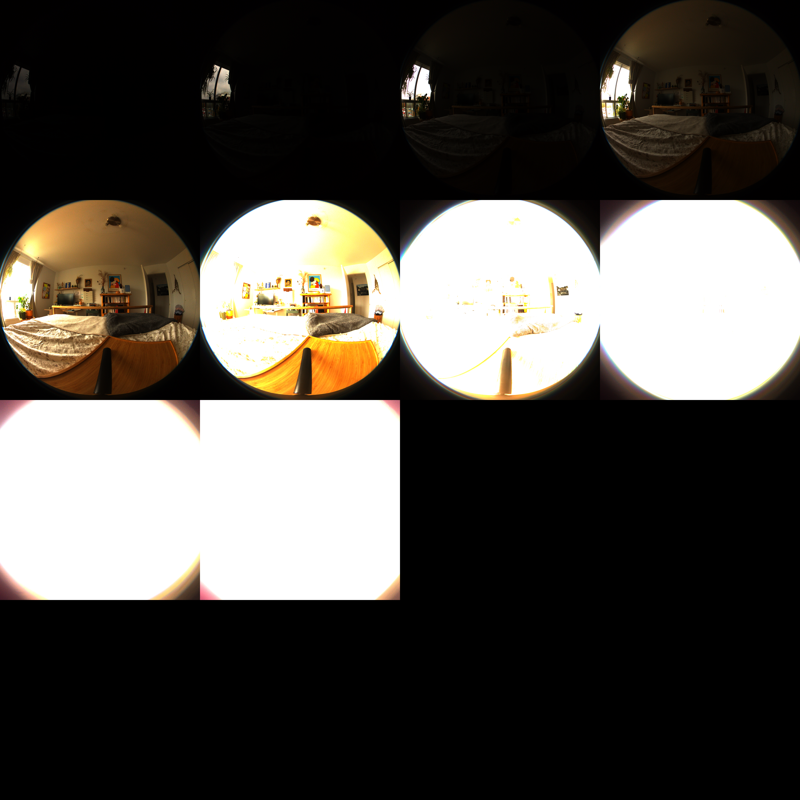

In [11]:
# MOSAIC PREVIEW OF PICTURES
mosaic = images_dict['left'].copy()
number_of_images = len(mosaic)

for i in range(0, ceil(sqrt(number_of_images))**2 - number_of_images):
    mosaic.append(np.zeros(images_dict['left'][0].shape).astype(np.uint8))
rows = []
for i in np.array_split(mosaic, ceil(sqrt(number_of_images))):
    rows.append(np.hstack(i))
mosaic = np.row_stack(rows)

display(
    Image.fromarray(mosaic).resize((800, 800))
)

## HDR

In [12]:
# CAMERA EXPOSURE TIMES
exposure_times = np.array([
    1/25000,
    1/6400,
    1/1600,
    1/400,
    1/100,
    1/25,
    1/6,
    1/1.6, #0.625
    5/2, #2.5
], dtype=np.float32)

exposure_times

array([3.9999999e-05, 1.5625000e-04, 6.2499999e-04, 2.4999999e-03,
       9.9999998e-03, 3.9999999e-02, 1.6666667e-01, 6.2500000e-01,
       2.5000000e+00], dtype=float32)

In [13]:
# MERGE EXPOSURES TO HDR IMAGE
import cv2

merged_images = images_list[0:-1]
merge_debevec = cv2.createMergeDebevec()
hdr_debevec = merge_debevec.process(merged_images, times=exposure_times.copy())

# RESCALE HDR ALPHA
# VOIR CRISTOPE BOLDUC
r_percentile = np.percentile(hdr_debevec, 90)
alpha = 0.8 / (r_percentile + 1e-10)
hdr_rescaled = hdr_debevec * alpha

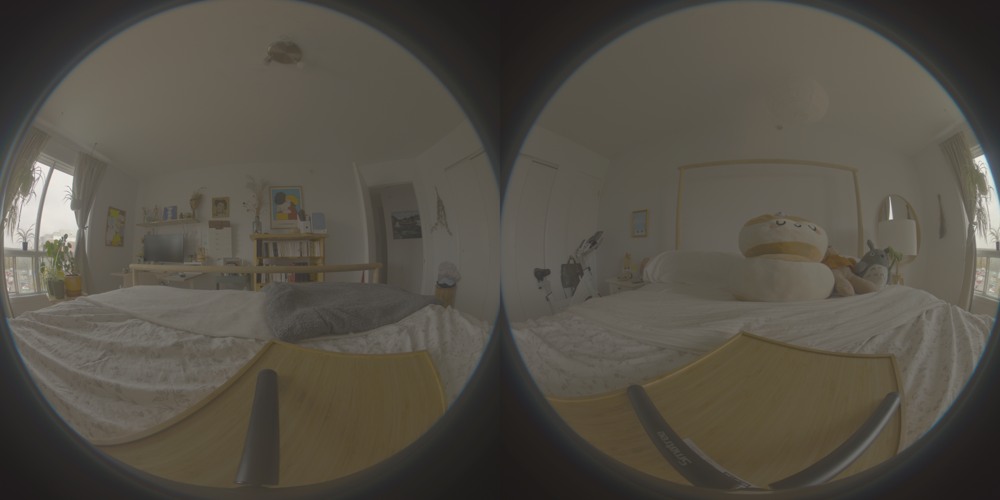

In [14]:
# TONEMAP HDR IMAGE
tonemap1 = cv2.createTonemap(gamma=5)
res_debevec = tonemap1.process(hdr_rescaled.copy())
res_debevec_8bit = np.clip(res_debevec*255, 0, 255).astype('uint8')

display(
    Image.fromarray(res_debevec_8bit).resize((1000,500))
)

In [15]:
# SAVE EXR IMAGE TO LOCAL COMPUTER FROM COLAB

# WRTIE EXR FILE TO COLAB DISK
imageio.imwrite('img.exr', res_debevec.astype("float32"))

# SAVE FROM BROWSER
# MIGHT NOT WORK IF NOT ON CHROME
from google.colab import files
files.download('img.exr')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

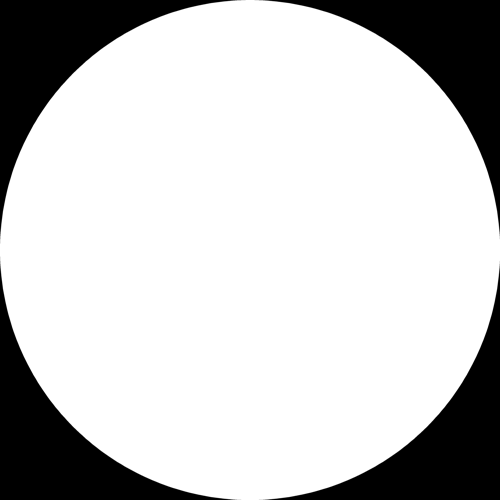

In [ ]:
# UTILS 
# CIRCULAR IMAGE CROP

def circular_map(image:np.array):
    height, width, R = image.shape
    # Create alpha layer
    alpha = Image.new('L', (height, width))
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((0,0),(height, width)),0,360,fill=255)
    #alpha_arr = np.where(np.array(alpha) == 255, 255, 0)
    return np.array(alpha)

x = circular_map(images_dict['left'][4])
display(
    Image.fromarray(np.dstack((x,x,x)).astype(np.uint8)).resize((500,500))
)